In [2]:
from helpers import *
import pandas as pd
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# auto reloading library (mainly for altering helpers.py)
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

training_filters = [
    {
        'feature': 'month',
        'operator': 'between',
        'value': [3, 9]
    }
]

validation_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2020-05-01', '2020-07-01']
    }
]

test_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2021-05-01', '2021-07-01']
    }
]

agg_strats = ['mean']

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

val_X, val_y = m_wrap.get_val(aggregated=True,y_scaled=False)#,drop_test=False,drop_val=False)

Xy = pd.concat([val_X, val_y.rename('pv_measurement')], axis=1)

In [3]:
#Xy = Xy[Xy['date_forecast'] > '2023-01-01']

In [4]:
pd.set_option('display.max_rows', None)
Xy[['building_id','pv_measurement']].groupby('building_id').nunique()

,pv_measurement
building_id,
a,1115
b,638
c,100


In [5]:
# remove 'mean' from each column name
Xy.columns = [col.replace('mean_', '') for col in Xy.columns]

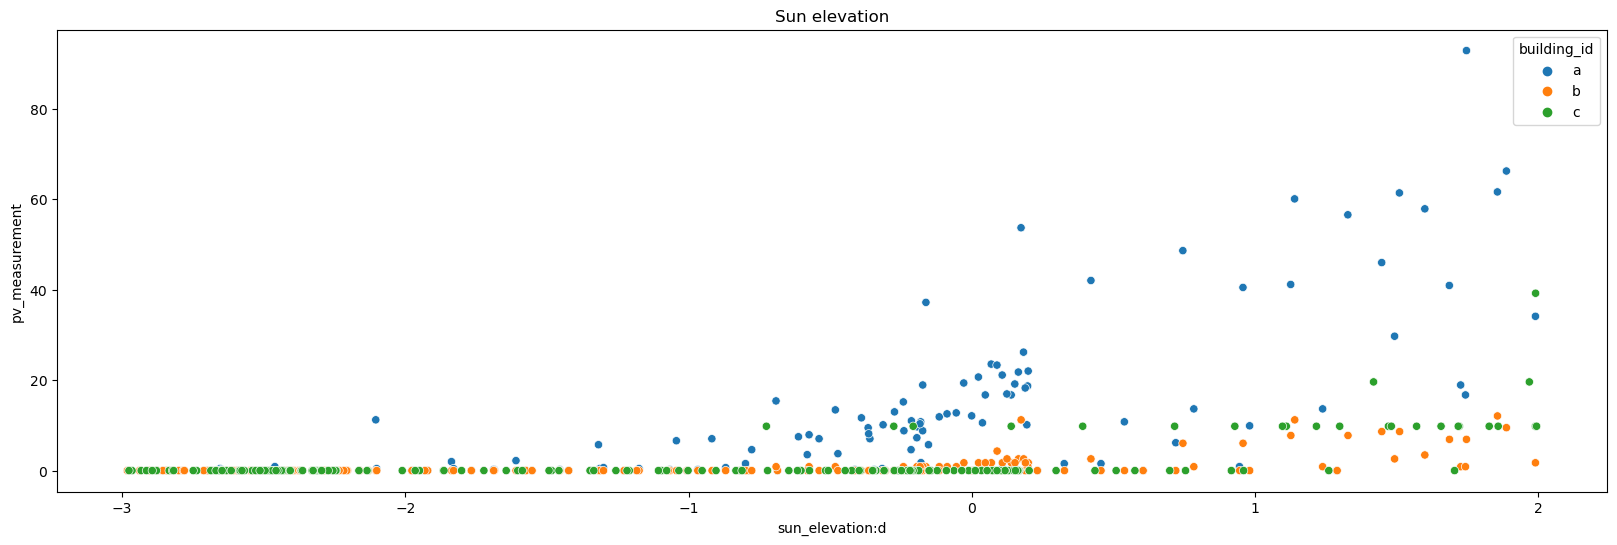

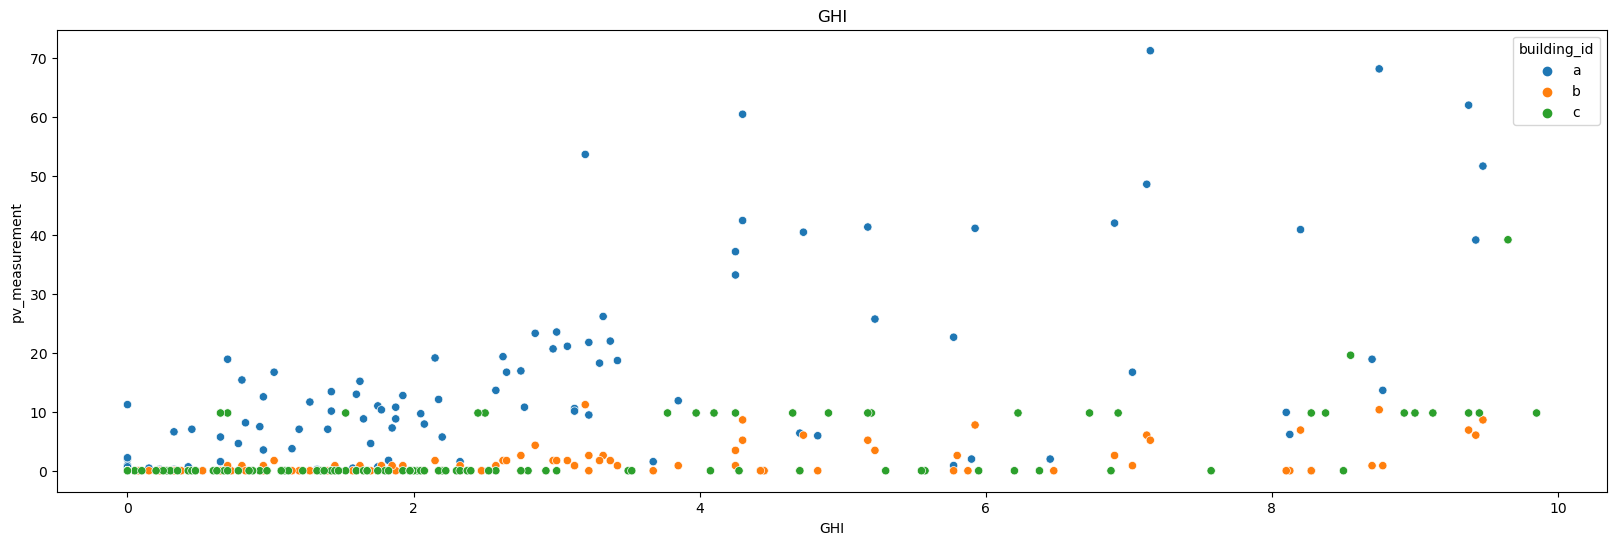

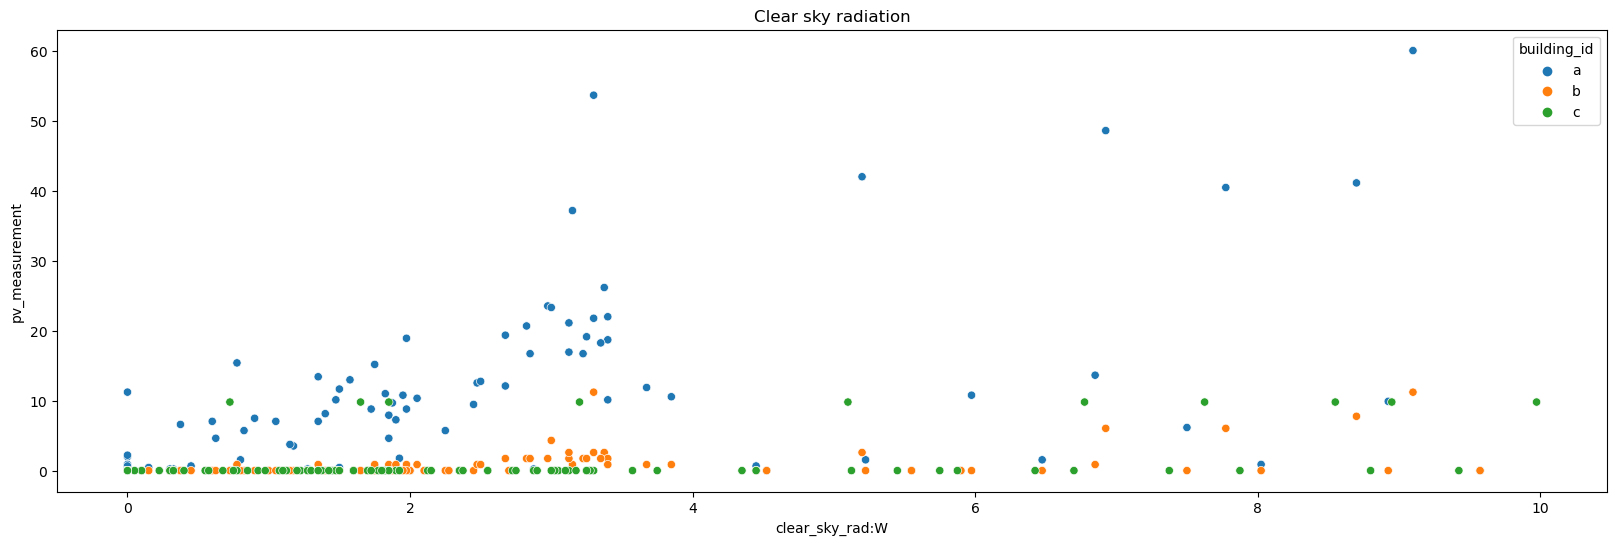

In [6]:
target = 'pv_measurement'

plt.figure(figsize=(20,6))
filter = Xy['sun_elevation:d'].between(-3, 2)
sns.scatterplot(data=Xy[filter], x='sun_elevation:d', y=target, hue='building_id')
plt.title('Sun elevation')
plt.show()

plt.figure(figsize=(20,6))
filter = Xy['GHI'].between(0, 10)
# filter = Xy['building_id'] != 1
sns.scatterplot(data=Xy[filter], x='GHI', y=target, hue='building_id')
plt.title('GHI')
plt.show()

plt.figure(figsize=(20,6))
filter = Xy['clear_sky_rad:W'].between(-1, 10)
# filter = Xy['building_id'] != 1
sns.scatterplot(data=Xy[filter], x='clear_sky_rad:W', y=target, hue='building_id')
plt.title('Clear sky radiation')
plt.show()
